In [1]:
import numpy as np
import pandas as pd
import cv2 as cv

In [4]:
original_metadata = pd.read_csv('./data/downloaded_data/diverse/ddidiversedermatologyimages/ddi_metadata.csv')
split_metadata = pd.read_csv('./data/diverse/labels.csv', dtype={'label': int, 'file_name': str})

print(original_metadata.head())
print(split_metadata.head())

   Unnamed: 0  DDI_ID    DDI_file  skin_tone  malignant   
0           0       1  000001.png         56       True  \
1           1       2  000002.png         56       True   
2           2       3  000003.png         56       True   
3           3       4  000004.png         56       True   
4           4       5  000005.png         12       True   

                           disease  
0                 melanoma-in-situ  
1                 melanoma-in-situ  
2                mycosis-fungoides  
3  squamous-cell-carcinoma-in-situ  
4             basal-cell-carcinoma  
  file_name  label
0    000001     56
1    000002     56
2    000003     56
3    000004     56
4    000005     12


In [6]:
original_metadata['skin_tone'].value_counts()

skin_tone
34    241
12    208
56    207
Name: count, dtype: int64

In [7]:
original_metadata = pd.read_csv('./data/downloaded_data/fp17k/fitzpatrick17k.csv')
split_metadata = pd.read_csv('./data/fp17k/labels.csv', dtype={'label': int, 'file_name': str})

print(original_metadata.head())
print(split_metadata.head())

                            md5hash  fitzpatrick_scale  fitzpatrick_centaur   
0  5e82a45bc5d78bd24ae9202d194423f8                  3                    3  \
1  fa2911a9b13b6f8af79cb700937cc14f                  1                    1   
2  d2bac3c9e4499032ca8e9b07c7d3bc40                  2                    3   
3  0a94359e7eaacd7178e06b2823777789                  1                    1   
4  a39ec3b1f22c08a421fa20535e037bba                  1                    1   

                             label nine_partition_label three_partition_label   
0  drug induced pigmentary changes         inflammatory        non-neoplastic  \
1                  photodermatoses         inflammatory        non-neoplastic   
2                   dermatofibroma        benign dermal                benign   
3                        psoriasis         inflammatory        non-neoplastic   
4                        psoriasis         inflammatory        non-neoplastic   

    qc                                

In [3]:
import data.skin_color_dataset as scd
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

dataset = scd.FP17KDataset(subset='train', colorspace='rgb')

0     3
1     1
3     1
5     4
7     5
8     2
9     1
10    2
13    1
14    2
Name: label, dtype: int64
0     34
1     12
3     12
5     34
7     56
8     12
9     12
10    12
13    12
14    12
Name: label, dtype: int64


(3, 256, 256)


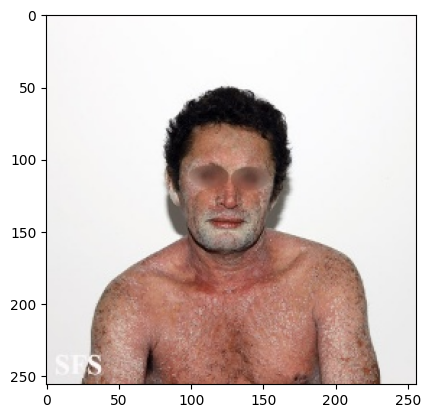

In [79]:
img = dataset.get_item_np(0)
plt.imshow(np.transpose(img, (1, 2, 0)))

print(img.shape)

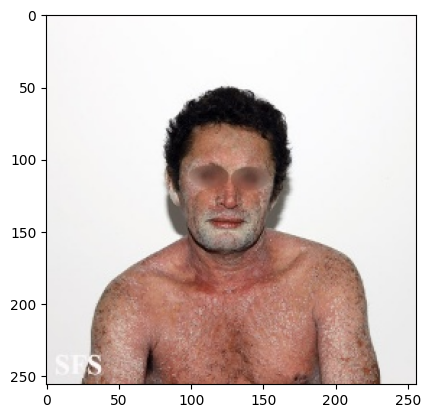

In [83]:
# # skin color thresholding
# 0.0 <= (r-g)/(r+g) <= 0.5

# rg_ratio = (img[0] - img[1]) / (img[0] + img[1] + 1e-6)
# # b / (r+g) <= 0.5
# b_ratio = img[2] / (img[0] + img[1] + 1e-6)
# skin_mask = (b_ratio <= 1)

# Cr ≤ 1.5862 × Cb + 20
# Cr ≥ 0.3448 × Cb + 76.2069
# Cr ≥ -1. × Cb + 234.5652
# Cr ≤ -1.15 × Cb + 301.75
# Cr ≤ -2.2857 × Cb + 432.85
img_ycrcb = cv.cvtColor(np.transpose(img, (1, 2, 0)), cv.COLOR_RGB2YCrCb)
img_ycrcb = np.transpose(img_ycrcb, (2, 0, 1))
img_y = img_ycrcb[0]
img_cr = img_ycrcb[1]
img_cb = img_ycrcb[2]


skin_mask = (img_cr <= 1.5862 * img_cb + 20) & \
            (img_cr >= 0.3448 * img_cb + 76.2069) & \
            (img_cr >= -1. * img_cb + 234.5652) & \
            (img_cr <= -1.15 * img_cb + 301.75) & \
            (img_cr <= -2.2857 * img_cb + 432.85)

img_without_skin = img.copy()
img_without_skin[0][~skin_mask] = 0.0
img_without_skin[1][~skin_mask] = 0.0
img_without_skin[2][~skin_mask] = 0.0

plt.imshow(np.transpose(img_without_skin, (1, 2, 0)))

In [8]:
import pandas as pd

df = pd.read_csv('./data/dermquest/skin_color_prediction.csv')

In [9]:
df.value_counts('skin_type')

skin_type
12    106
34     31
Name: count, dtype: int64

nn_skin_type
12    2488
34     205
56       1
Name: count, dtype: int64


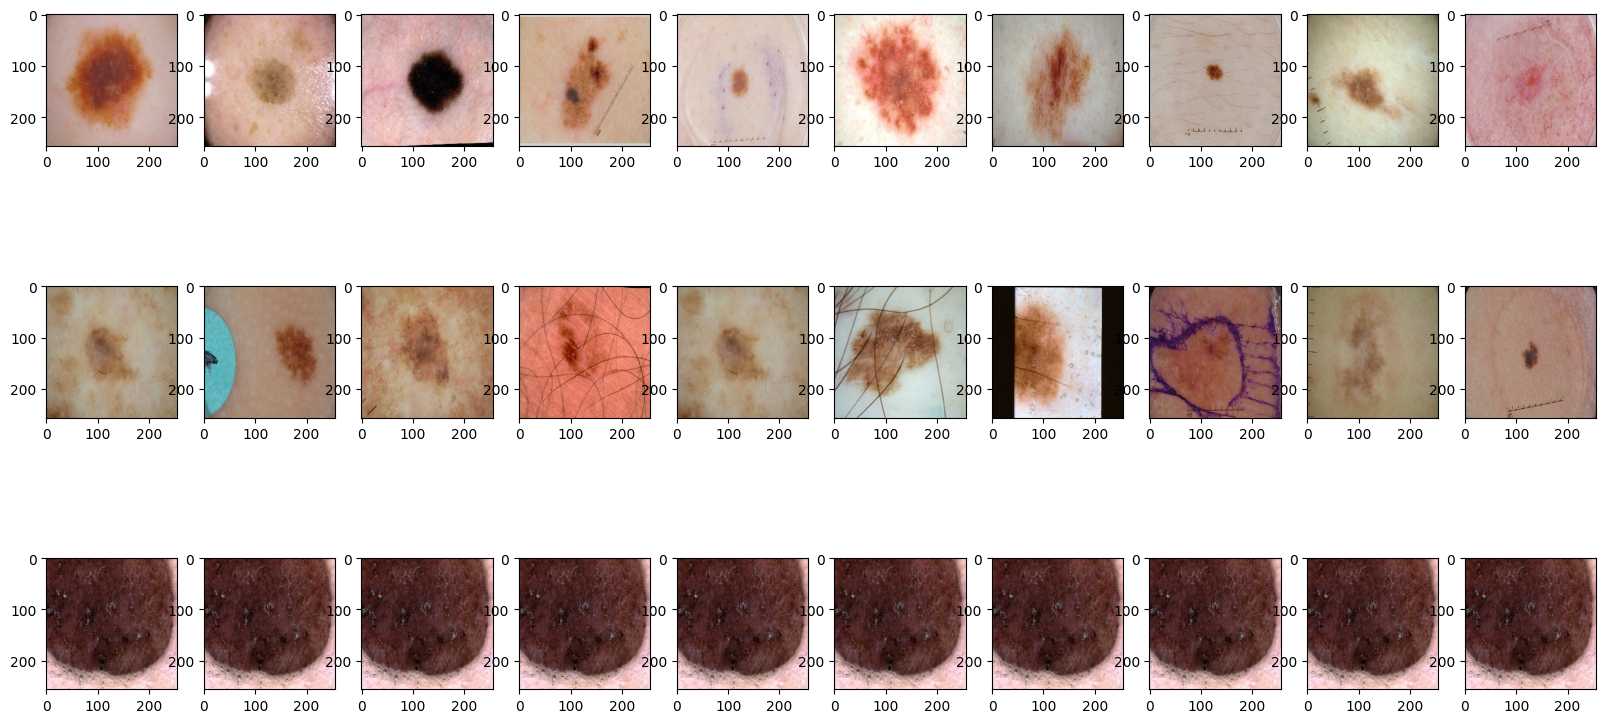

nn_skin_type
12    61
34     6
56     2
Name: count, dtype: int64


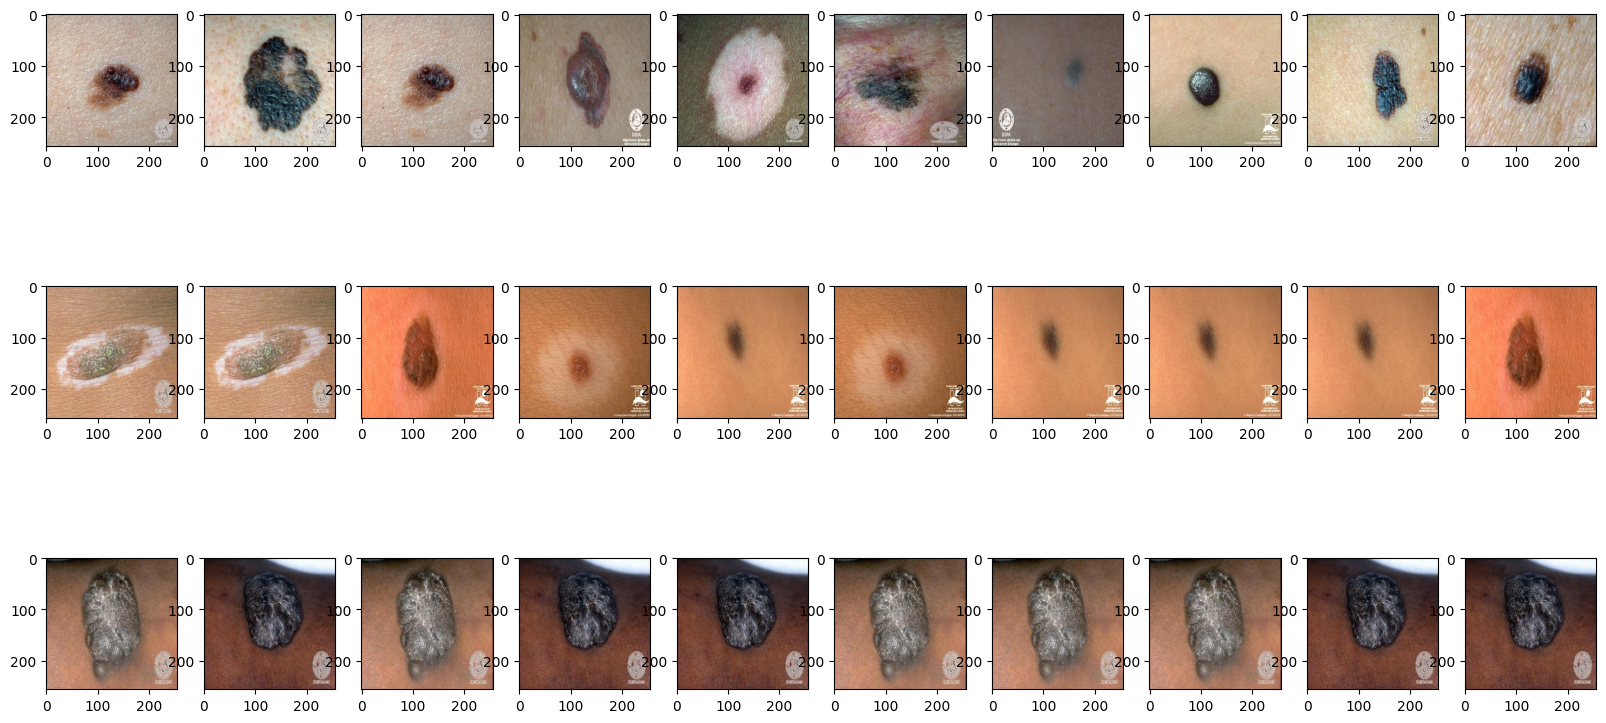

nn_skin_type
12    93
34    43
56     1
Name: count, dtype: int64


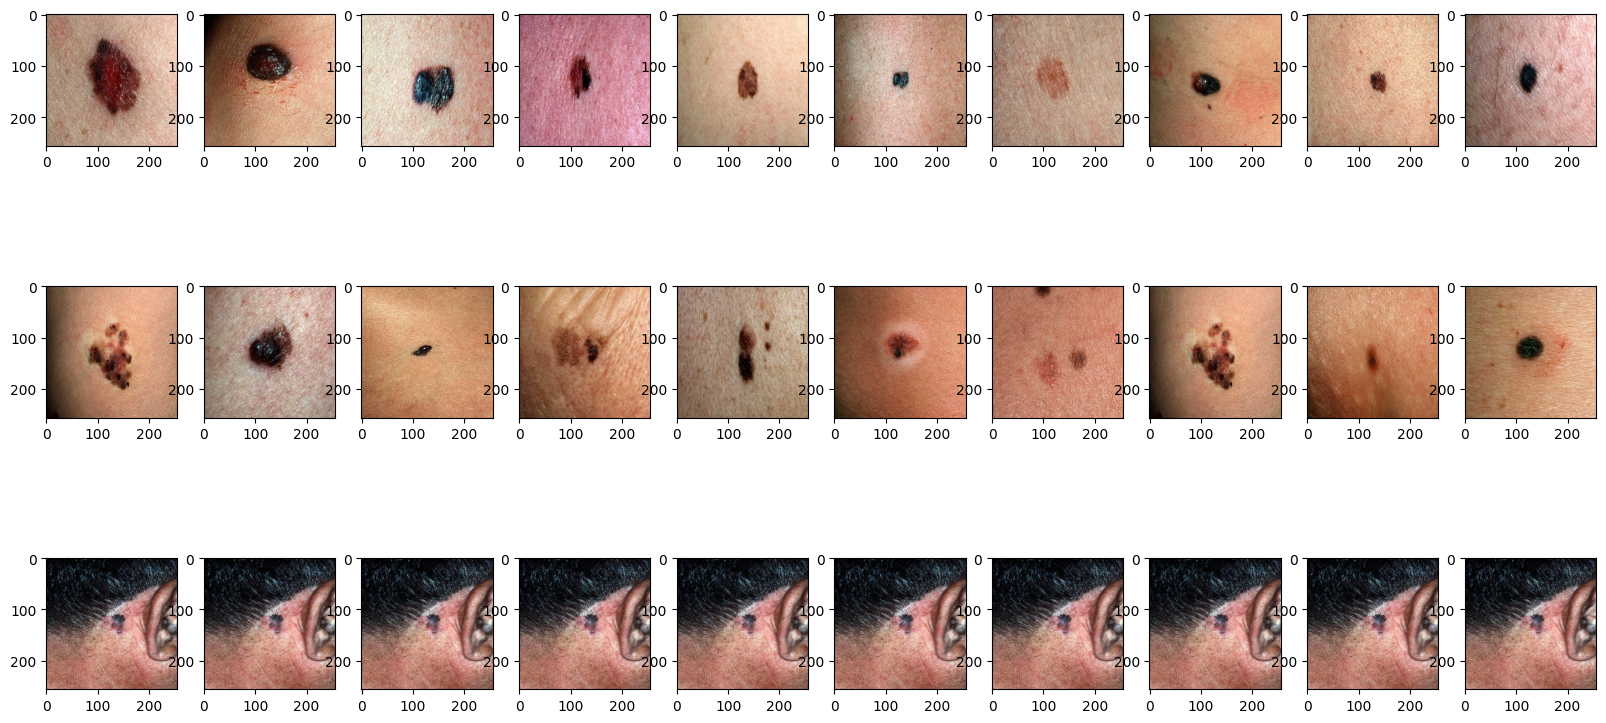

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
from pathlib import Path

datasets = ['isic', 'dermis', 'dermquest']
labels = [12, 34, 56]


for dataset in datasets:
    fig, axs = plt.subplots(3, 10, figsize=(20, 10))
    df = pd.read_csv(f'./data/{dataset}/skin_color_prediction.csv')
    print(df['nn_skin_type'].value_counts())
    for label in labels:
        # plot 10 images of each class
        df_ = df[df['nn_skin_type'] == label]
        if len(df_) == 0:
            continue
        df_ = df_.sample(10, replace=True)
        for i in range(10):
            row = df_.iloc[i]
            file_path = Path(f'./data/{dataset}')
            file_path = list(file_path.glob(f'**/{row["file_name"]}*'))[0]
            img = cv.imread(str(file_path))
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            axs[labels.index(label)][i].imshow(img)
    plt.show()